# Processing sim data in 3D volume to 2D image
In this notebook, we aim to investigate in the reduction of the problem to 2d-image classification. We start from temporal data in 3d volume (simulation by CJ) and try to build a 2d-image representation of the simulation.

To this aim, we have to define certain parameters. In particular,
- we've to choose the event time-horizon `T`
- we've to choose the particles `P` that deposit energy that lead to scintillation
- we've to choose the primary event `E0` that determines the start of the event

Then, we can proceed as follow:
1. scale the time w.r.t. the time of the primary event `E0`
1. select the entries from particles `P` and time within the time-horizon `T`
1. create a 2d-image and map each `Edep`>0 using `x`, `y` coordinates
In fact, we can discard the `z` coordinate because the fibers are placed along the z-axis and all it will be impossible to distinguish the `z` coordinate from SiPM readouts.

## Define event time-horizon
We analysed the time and space of muon passages in the [notebook] and observed that in the original pilot data, the muon cross the LAr volume in  less than ~`18ns`.

However, the secondary energy depositions could occur delayed in time. In particular, we observed that electrons and photons depositions have occurred very close in time with the muon deposition. In fact, most of the electrons and gammas depositions occur before `30ns` and the muon depositions starts on average at `~20ns`.

[notebook]: analysis_muon_particles.ipynb

## Define particles that lead to scintillation
Not all the energy deposited by any particles will lead to scintillation, indeed most of the energy deposition will then captured by other particles and so on. Some particles will directly cause the scintillation process, they are electrons `e-`.

So, the fibers that are placed in the LAr volume will guide the optical photons to the SiPMs. The fibers will them capture two kind of photons:
- primary photons, e.g. generated by Ar41 de-excitation
- optical photons generated by scintillation

However, at the current level of simulation we have no optical-photons entries because the scintillation process is not simulated. Then, considering this first stage of energy-deposition, we can focus our study on:
- energy deposited by **electrons**
- energy deposited by **primary photons**

### Observation:
1. Most of the primary photons will cause Compton scattering or Pair production, then producing electrons more or less directly. Then, primary photons will deposit their energy on the volume border releasing only a few `keV`.

## Define primary event
We can define as primary event, the **first entry of a muon particle in the LAr volume**. 
It could be a good choice because there is any relation between the time of the first muon entry in LAr and the energy deposition by the selected particles.

**Note:** once we will pass to feeding a ML model, we could also consider to introduce some time shifting in order to vary the observed events, maybe cutting some late depositions or anticipate some others. This could later improve the learning capability w.r.t. the time window.


In [3]:
# import libraries and load data (only meaningful fields)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 30})

fields = ["PID", "ParentTrackID", "energydeposition", "kineticenergy", "time", "x", "y", "z", "eventnumber", "parentnucleusPID", "creatorprocess"]
file_path = os.path.join("..", "Data", "output10000.csv")
df = pd.read_csv(file_path, index_col=False)

In [8]:
p_selection = df[(df.PID.isin([11,22])) & (df.energydeposition>0)].sort_values("time")

primary = df[df.PID==13].sort_values("time").groupby("eventnumber").first().reset_index()
primary_time = primary[["eventnumber", "time"]]

p_selection = pd.merge(p_selection, primary_time, left_on="eventnumber", right_on="eventnumber", suffixes=("", "_m"))
p_selection["time"] = p_selection["time"] - p_selection["time_m"]
p_selection[p_selection.time<0]

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,eventnumber,tracknumber,creatorprocess,parentnucleusPID,time_m
691,11,779,1689.620000,4796.71000,-0.0811,1921.8500,-273.428,543.0080,-0.781425,0.350170,-0.516485,1436,867,compt,0,14.0836
692,11,779,1169.010000,3627.70000,-0.0617,1916.6300,-273.417,539.6970,-0.390919,0.713829,-0.581061,1436,867,compt,0,14.0836
693,11,779,888.276000,2739.43000,-0.0466,1917.0200,-269.627,536.3900,0.158981,0.258047,-0.952962,1436,867,compt,0,14.0836
694,11,779,753.817000,1985.61000,-0.0350,1917.5700,-268.736,533.0990,-0.298186,0.732645,-0.611814,1436,867,compt,0,14.0836
695,11,779,129.592000,1725.67000,-0.0321,1917.3200,-268.113,532.5790,-0.159192,0.567057,-0.808149,1436,867,compt,0,14.0836
696,11,779,626.001000,1099.67000,-0.0244,1916.9600,-266.843,530.7700,0.238861,-0.450022,-0.860480,1436,867,compt,0,14.0836
697,11,779,372.228000,727.44000,-0.0194,1917.3000,-267.483,529.5460,0.311965,0.889320,-0.334346,1436,867,compt,0,14.0836
698,11,779,346.577000,380.86300,-0.0162,1917.5700,-266.702,529.2520,-0.939808,-0.234340,-0.248687,1436,867,compt,0,14.0836
699,11,779,371.866000,8.99729,-0.0147,1917.2400,-266.784,529.1650,0.367044,0.862763,0.347733,1436,867,compt,0,14.0836
700,11,779,8.997290,0.00000,-0.0147,1917.2400,-266.784,529.1650,0.367044,0.862763,0.347733,1436,867,compt,0,14.0836


**Note:** There are entries with shifted-time < 0. **Why?** Because the first entry of muon doesn't correspond to its enter in the LAr but its first energy deposition. Then, such electrons could be produced by muon ionization and deposit their energy before the first energy deposition by muon.

Remember that our aim is to discard all the energy depositions that are far from the first muon energy deposition. Then, we really don't care about this detail.

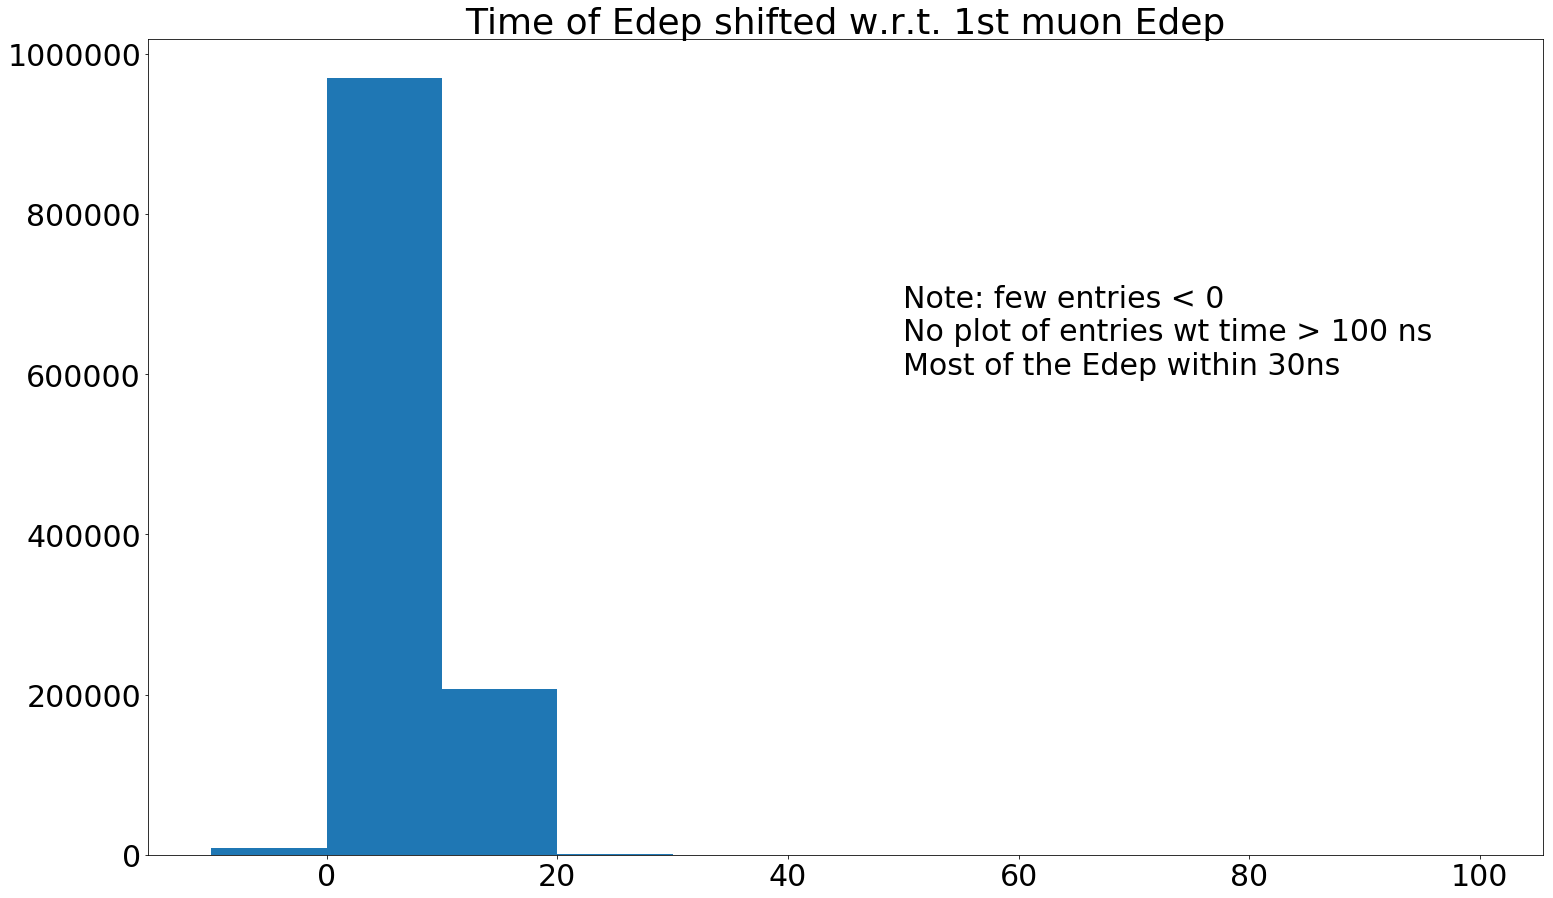

In [21]:
note =  "Note: few entries < 0\n" \
        "No plot of entries wt time > 100 ns\n" \
        "Most of the Edep within 30ns"
plt.hist(p_selection.time, bins=[-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title("Time of Edep shifted w.r.t. 1st muon Edep")
plt.text(50, 600000, note)
plt.show()

In [23]:
t_p_selection = p_selection[p_selection.time < 30]
t_p_selection


,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,eventnumber,tracknumber,creatorprocess,parentnucleusPID,time_m
0,11,1,333.75200,265.5080,0.0026,1920.0200,-279.696,555.848,0.249726,-0.315518,-0.915470,8437,158,muIoni,0,13.9966
1,11,1,265.50800,0.0000,0.0035,1920.0700,-279.760,555.664,0.249726,-0.315518,-0.915470,8437,158,muIoni,0,13.9966
2,11,1,457.00500,420.8700,0.0276,1912.8800,-280.208,553.886,-0.119195,0.069474,-0.990437,8437,159,muIoni,0,13.9966
3,11,1,312.67600,108.1930,0.0292,1912.8300,-280.179,553.479,-0.967200,-0.253928,-0.006717,8437,159,muIoni,0,13.9966
4,11,1,108.19300,0.0000,0.0295,1912.7800,-280.191,553.479,-0.967200,-0.253928,-0.006717,8437,159,muIoni,0,13.9966
5,11,1,249.73400,39089.5000,0.1803,1867.9500,-285.631,544.422,-0.925272,-0.150204,-0.348298,8437,160,muIoni,0,13.9966
6,11,160,298.41200,0.0000,0.1814,1867.8700,-285.858,544.418,-0.348298,-0.937212,-0.017959,8437,706,eIoni,0,13.9966
7,11,1,377.52200,35101.2000,0.1872,1866.0300,-286.015,543.729,-0.945411,-0.167973,-0.279256,8437,160,muIoni,0,13.9966
8,11,1,332.40100,0.0000,0.2187,1856.9600,-286.855,542.091,-0.292615,-0.642276,-0.708420,8437,161,muIoni,0,13.9966
9,11,1,2534.42000,31781.6000,0.2349,1852.8200,-288.635,538.889,-0.909206,-0.201698,-0.364227,8437,160,muIoni,0,13.9966
